### Giving Life to Equations

#### Artificial Learning: A First Example.

This notebook implements our first functional Perceptron in its simplest possible form: **a single layer with a single neuron**. We will use only Python and NumPy to see the theory from Chapters 1, 2, and 3 in its purest form.

The objective is to apply backpropagation to a real and quite rudimentary image classification problem. As our architecture is the simplest that exists, we will see how the general learning equation <<eq-dE_dW-0>> simplifies in a beautiful and intuitive way. The calculation of the weights' gradient (`∂E/∂W`), for example, will not have that clumsy column-vector of matrices, as we will see.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Function to download and prepare an image from a URL
def download_and_prepare_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('L')
    img_array = np.array(img) / 255.0
    img_array = np.where(img_array > 0.7, 1, 0)
    return img_array.flatten()

# URLs of the "little faces" images
base_url = 'https://raw.githubusercontent.com/aleperrod/perceptron-book/2e9af4436dd7317ea18fbcae583429cccc944ef0/carinhas/'
urls = [
    base_url + 'gross1.png', base_url + 'gross2.png', base_url + 'gross3.png',
    base_url + 'thin1.png',  base_url + 'thin2.png',  base_url + 'thin3.png'
]

X_train = np.array([download_and_prepare_image(url) for url in urls])
z_train = np.array([0, 0, 0, 1, 1, 1])

# Test images
url_teste_thin = base_url + 'thin4.png'
url_teste_gross = base_url + 'gross4.png'
x_teste_thin = download_and_prepare_image(url_teste_thin)
x_teste_gross = download_and_prepare_image(url_teste_gross)

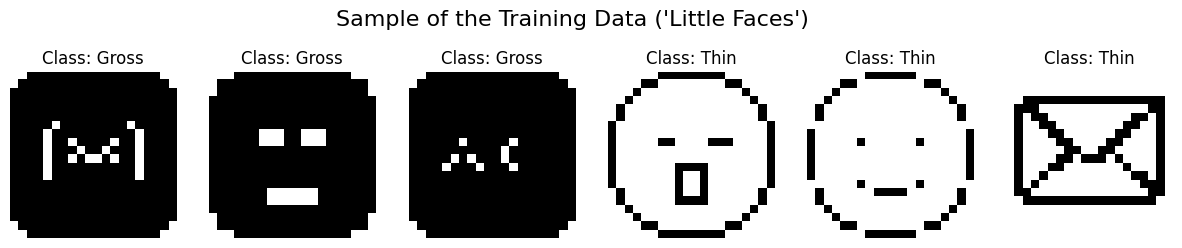

In [2]:
# Visualizing our training data
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(20, 20), cmap='gray') # Reshape error, corrected to 20x20
    ax.set_title(f"Class: {'Gross' if z_train[i] == 0 else 'Thin'}")
    ax.axis('off')
plt.suptitle("Sample of the Training Data ('Little Faces')", fontsize=16)
plt.show()

#### Step 2: Defining the Tools (Functions)

As we are building everything "by hand," we define our tools as separate functions. Note that, as our Perceptron has only one neuron, the output `P` and the error `E` are single values (scalars), which simplifies their derivatives.

In [3]:
# Activation Functions and their derivatives
def sigmoid(y):
    return 1 / (1 + np.exp(-y))

def sigmoid_derivative(a):
    return a * (1 - a)

# Cost Function (Mean Squared Error) and its derivative
# z and P are scalars here
def mean_squared_error(z, P):
    return (z - P)**2

def mean_squared_error_derivative(z, P):
    return 2 * (P - z) # Keeping the factor of 2 for fidelity to the formal derivative

# Function to initialize the parameters of our neuron
def initialize_parameters(input_dim):
    # W is a 1D vector (not a matrix) with 400 weights.
    W = np.random.randn(input_dim) * 0.01
    # b is a single number (scalar)
    b = 0.0
    return W, b

#### Step 3: Training "by Hand" (Example by Example)

This is the heart of our notebook. The training loop implements the theory of artificial learning. For each image `x` and its label `z`, the process is:

1.  **Forward Pass:** We calculate the output `P`, which in this case is a single number.
2.  **Backpropagation:** We calculate the gradients. Here lies the beauty of the simplification:
    * The error "delta" `dE/dy` is a scalar, as there is only one linearity, `y`.
    * The gradient of the weights, `dE/dW`, is calculated by multiplying this scalar delta by the input vector `x`. The equation `∂E/∂W = (∂E/∂a * ∂a/∂y) * x` manifests here. The expression <<eq-dE_dW-0>> simplifies because, in this example, the weight matrix `W` reduces to a row-vector!
3.  **Update:** We adjust `W` and `b` using the calculated gradients.

In [4]:
# --- Hyperparameters and Initialization ---
learning_rate = 0.1
epochs = 30
W, b = initialize_parameters(X_train.shape[1])

cost_history = []

print("Starting the training in Python/NumPy (corrected version)...")
for i in range(epochs):
    total_epoch_cost = 0
    # The inner loop iterates over each example individually
    for x, z in zip(X_train, z_train):

        # --- 1. Forward Pass ---
        # y = W . x + b (dot product between two vectors -> scalar)
        y = np.dot(W, x) + b #<1>
        # P = a(y) (activation on a scalar -> scalar)
        P = sigmoid(y) #<2>

        # --- 2. Cost Calculation ---
        cost = mean_squared_error(z, P)
        total_epoch_cost += cost

        # --- 3. Backpropagation (with scalars) ---
        # Initial delta: dE/dy = dE/dP * dP/dy (product of scalars)
        dE_dP = mean_squared_error_derivative(z, P)
        dP_dy = sigmoid_derivative(P)
        dE_dy = dE_dP * dP_dy

        # Gradients of the parameters
        # dE/dW = dE/dy * d(y)/dW = dE/dy * x
        # This is the simplified form! It is the multiplication of a scalar (dE_dy) by a vector (x).
        dE_dW = dE_dy * x
        # dE/db = dE/dy * d(y)/db = dE/dy * 1
        dE_db = dE_dy

        # --- 4. Parameter Update ---
        W -= learning_rate * dE_dW
        b -= learning_rate * dE_db

    # End of epoch
    average_cost = total_epoch_cost / len(X_train)
    cost_history.append(average_cost)
    if (i + 1) % 5 == 0:
      print(f"Epoch {i + 1}/{epochs} - Average Cost: {average_cost.item():.6f}")

print("Training finished!")

Starting the training in Python/NumPy (corrected version)...
Epoch 5/30 - Average Cost: 0.007729
Epoch 10/30 - Average Cost: 0.003475
Epoch 15/30 - Average Cost: 0.002239
Epoch 20/30 - Average Cost: 0.001647
Epoch 25/30 - Average Cost: 0.001301
Epoch 30/30 - Average Cost: 0.001074
Training finished!


#### Step 4: Analyzing the Training Results

One thing is to run the training, another is to know if it worked. The graph below shows the evolution of the average cost over the epochs.

A descending curve is the sign we are looking for: it indicates that the Perceptron was, with each pass through the data, adjusting its weights and becoming progressively better at its task, meaning the error was decreasing.


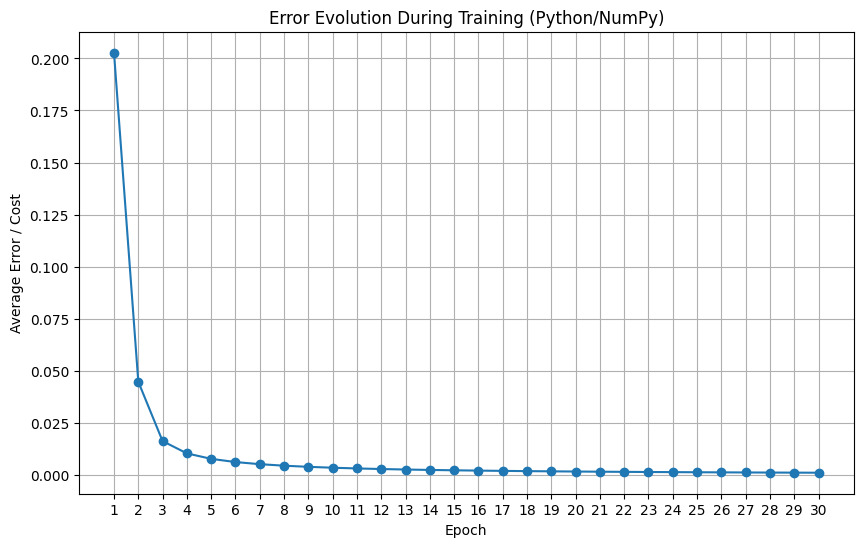

In [5]:
# Plot the cost function graph to see if the network learned
plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Average Error / Cost")
plt.title("Error Evolution During Training (Python/NumPy)")
plt.grid(True)
plt.xticks(np.arange(len(cost_history)), np.arange(1, len(cost_history) + 1))
plt.show()

#### Step 5: Testing the Model in Practice

After training, the true test of a neural network is its performance on data it has never seen before. The cell below defines a function that takes a test image, applies the _forward pass_ with the weights `W` and the bias `b` that we have just trained, and displays the image with the model's prediction alongside the real label.

The output of the Sigmoid function (`P`) is a number between 0 and 1. We can interpret it as the neuron's "confidence" that the image belongs to the "Thin" class (label 1). We use a threshold of 0.5 to make the final decision.

Run the cell to see if the Perceptron gets it right!

Starting tests with unseen data...

--- Testing image: 'Thin' ---
Neuron output (P): 0.9852
Final prediction: Thin


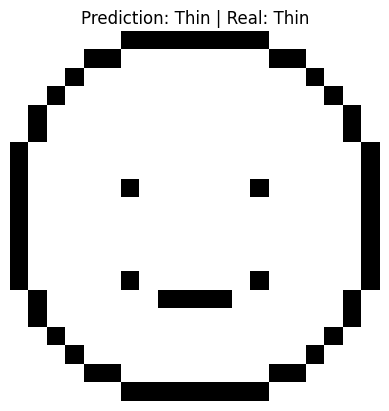



--- Testing image: 'Gross' ---
Neuron output (P): 0.1123
Final prediction: Gross


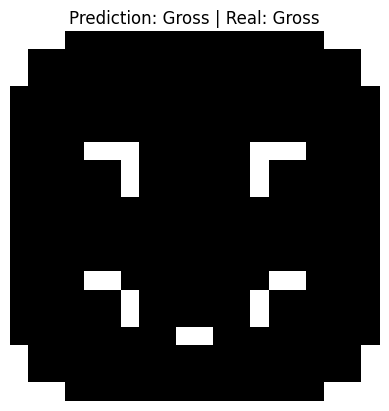

In [7]:
# Function to test the trained model on a new image
def test_model_numpy(image, real_label_str, W, b):
    # The Forward Pass is the same as inside the training loop
    y = np.dot(W, image) + b
    P = sigmoid(y)

    # The classification is based on a threshold of 0.5
    final_prediction = "Thin" if P > 0.5 else "Gross"

    # Displaying the results
    print(f"--- Testing image: '{real_label_str}' ---")
    print(f"Neuron output (P): {P.item():.4f}")
    print(f"Final prediction: {final_prediction}")

    plt.imshow(image.reshape(20, 20), cmap='gray')
    plt.title(f"Prediction: {final_prediction} | Real: {real_label_str}")
    plt.axis('off')
    plt.show()

# Testing with the two images we set aside
print("Starting tests with unseen data...\n")
test_model_numpy(x_teste_thin, "Thin", W, b)
print("\n" + "="*40 + "\n")
test_model_numpy(x_teste_gross, "Gross", W, b)